In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, ConfusionMatrixDisplay, mean_squared_error
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

## **Data Preprocessing**

Firstly, I need to load the dataset, fix the column names, and check for any missing or zero values. So after loading the dataset and fixing the column labels, I will perform some simple queries to check for null or zero values. After doing these checks I found that the dataset has no null or zero values. So, I will not need to fill in any missing data and can proceed directly to the data exploration and study the behavior of the features. 

In [2]:
def preprocess():
    
    path_to_file = "data/Dry_Bean_Dataset.xlsx"
    bean_df = pd.read_excel(path_to_file)
    
    bean_df.columns = bean_df.columns.str.strip().str.lower()
    bean_df = bean_df.rename(columns={'majoraxislength': 'major_axis_length', 'minoraxislength': 'minor_axis_length', 'convexarea': 'convex_area', 
                                      'equivdiameter': 'equiv_diameter', 'aspectration' : 'aspect_ratio', 'shapefactor1': 'shape_factor_1', 
                                      'shapefactor2': 'shape_factor_2', 'shapefactor3': 'shape_factor_3', 'shapefactor4': 'shape_factor_4'})

    return bean_df

bean_df = preprocess()

## **Exploratory Data Analysis**

I first will create two scatterplots to see if the data is clustered based on the class as I will eventually be training classification learners. As we can see from the scatterplots below, there are some clear clusters being formed based on the class of bean. We can especially see that the 'Bombay' class is much more discernable then the other classes. From these scatterplots I expect to see solid performance from my classification learners as the data is certainly being clustered according to the class despite some overlap. Furthermore, I will create a histogram of the classes to visualize the balance of the dataset. We can certainly see from the histogram that the data is not balanced, which is a hurdle we will attempt to overcome when trying to optimize the performance of the classification learner. However, it is worth noting that while the 'Bombay' class might be under-represented, it is the most discernable class in the dataset. Lastly, I will create boxplots to see the distribution of the 'area' feature based on the class. As we can see there is lots of overlap between most classes except for 'Bombay' which clearly has more area then the other classes on average. We can also see that there are a handful of outliers for each class, which is something I will try to address when optimizing the linear regression for area. 

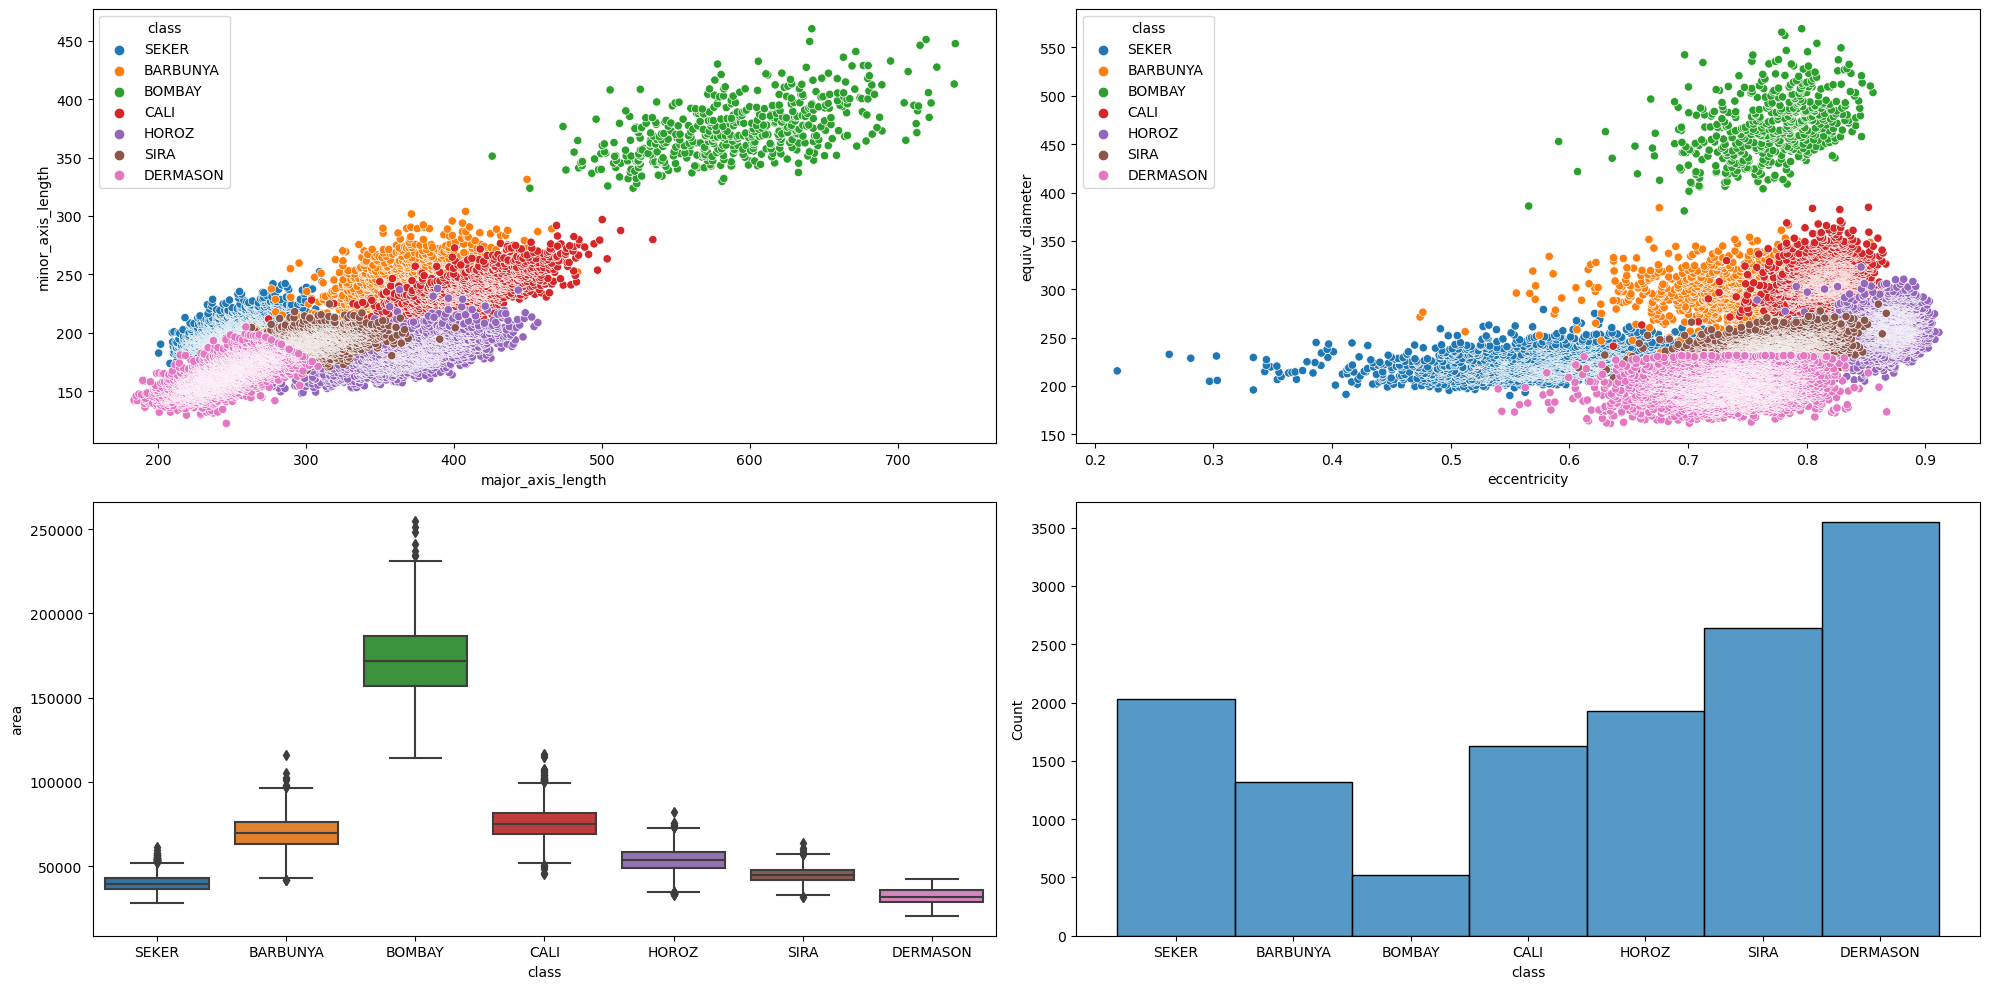

In [4]:
def exploratory_graphs():
    fig, axes = plt.subplots(2,2)
    plt.rcParams["figure.figsize"] = [20, 10]
    plt.rcParams["figure.autolayout"] = True

    sns.scatterplot(data=bean_df, x='major_axis_length', y='minor_axis_length', hue='class', ax=axes[0,0])
    sns.scatterplot(data=bean_df, x='eccentricity', y='equiv_diameter', hue='class', ax=axes[0,1])
    sns.boxplot(data=bean_df, x= 'class', y='area', ax=axes[1,0])
    sns.histplot(data=bean_df, x='class', ax=axes[1,1])

exploratory_graphs()

## **Feature Engineering**

Now that I have done some preliminary study of the dataset, I want to study the distributions of each individual feature to see which regressors will be optimal for training the linear regression. So, I plotted the distributions of all the numerical features in the dataset to see which ones are normally distributed. The green curves represent the actual densities of the regressors whereas the purple curves represent the ideal normal distribution of the feature based on its unique statistical parameters. For the most part, the regressors are fairly well distributed; however, I want to see if I could improve the distribution of any features using the logarithmic transformation we went over in class. So, the second group of graphs represent the distribution of the regressors after applying the log transformation and we can see that some features are indeed benefitting from this transformation. Such regressors include 'perimeter', 'major_axis_length', and 'minor_axis_length' to name a few. So, I will apply the log transformation to these features to optimized the distributions of my regressors. I also want to study their variance and correlation with the response variable 'area'. This will allow me to make an informed decision on the best possible regressors for the linear regression. Hence, we can see from the 'agg_df' that 'perimeter', 'major_axis_length', and 'minor_axis_length' are the top three regressors in terms of both their variance and correlation. Because these three regressors are highly correlated with 'area', I expect to see solid performance when training the linear regression using these features.  

In [5]:
def display_feature_distributions(df):

    fig, ax = plt.subplots(4, 4)
    plt.rcParams["figure.figsize"] = [20, 10]
    plt.rcParams["figure.autolayout"] = True
    
    from itertools import product
    lst = [np.arange(0, 4), np.arange(0, 4)]
    couples = product(*lst) 
    
    for i, j in couples:
        feature = df.columns[4 * i + j]
        values = df[feature]
        ave = values.mean()
        sd = values.std()
        sns.kdeplot(x=values, fill=True, alpha=0.3, color='darkgreen', ax=ax[i, j]);
        sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='purple', ax=ax[i, j]);
        plt.tight_layout

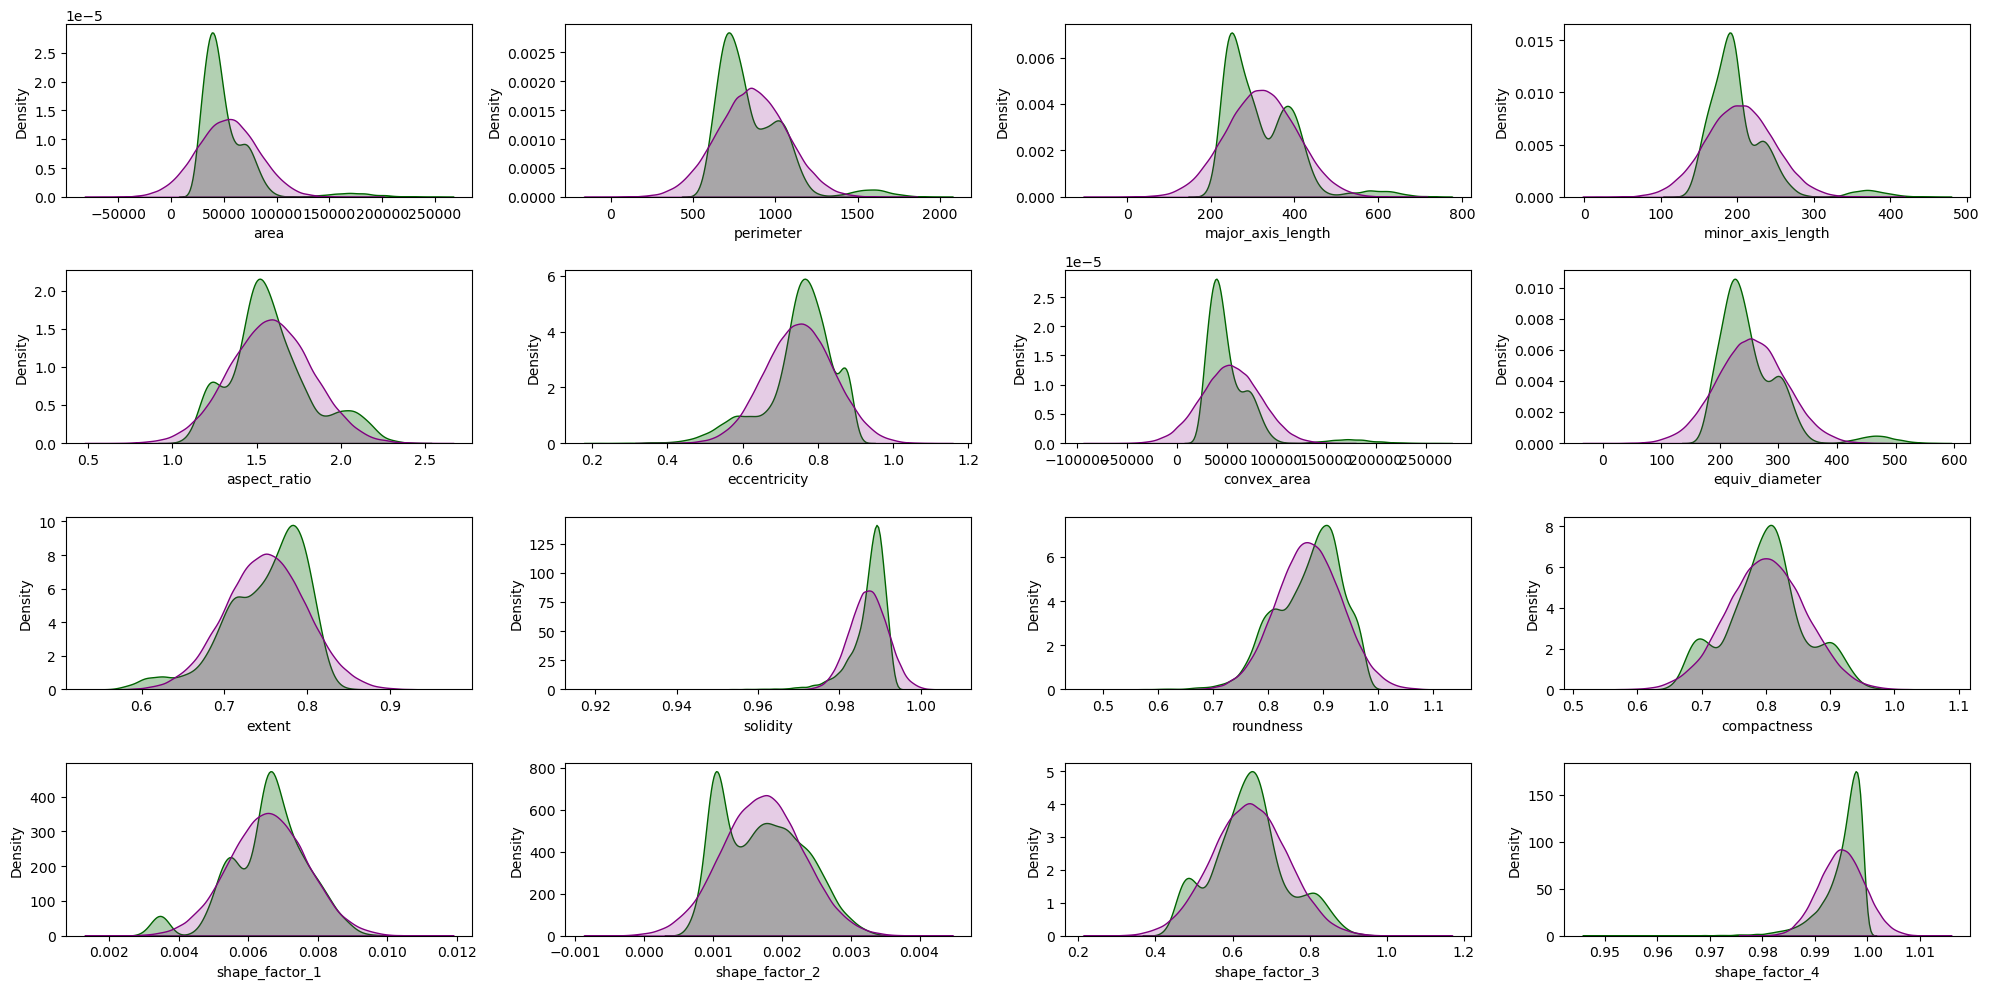

In [6]:
features_df = bean_df.drop(columns='class')
display_feature_distributions(features_df)

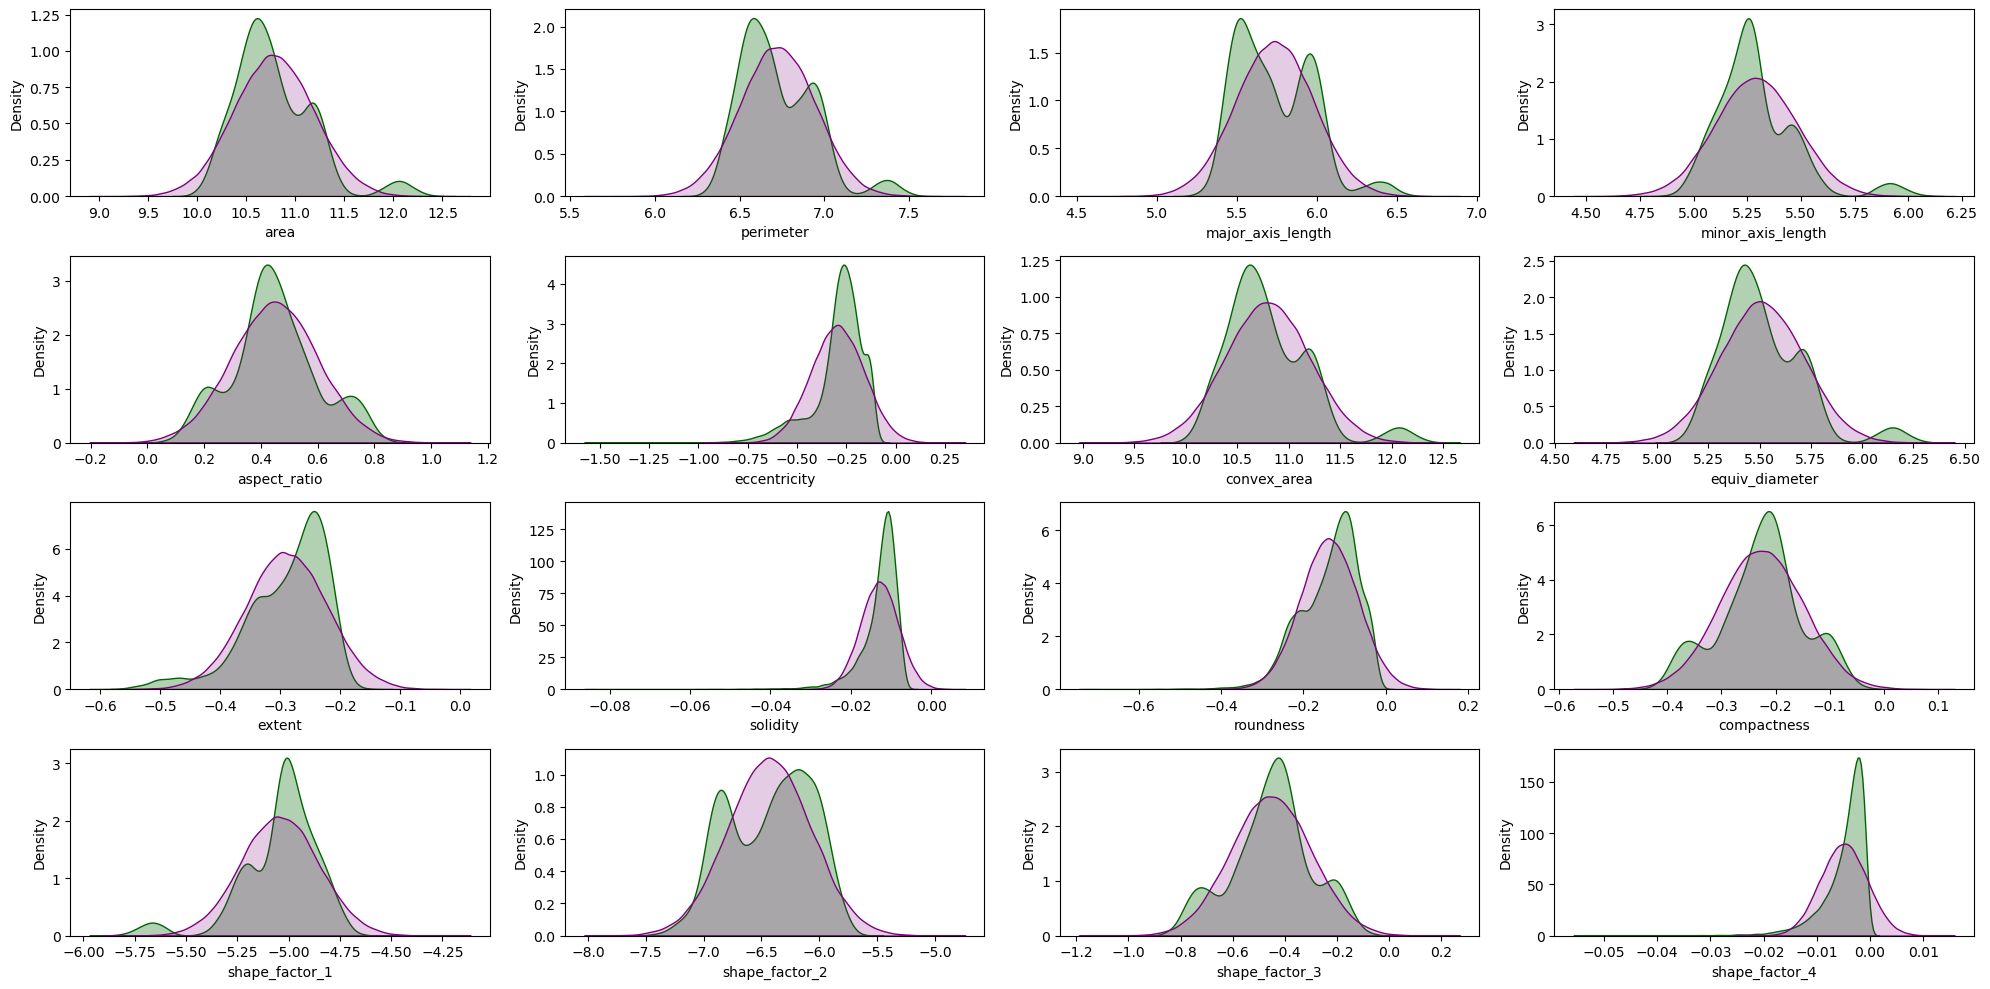

In [7]:
log_df = np.log(features_df.where(features_df > 0, np.nan))
display_feature_distributions(log_df)

In [8]:
def log_transform(column_names, df):
    df[column_names] = np.log(df[column_names])
    return df

In [9]:
features_df = bean_df.drop(columns='class')
log_features_df = log_transform(['perimeter', 'major_axis_length', 'minor_axis_length', 'convex_area', 'equiv_diameter', 'aspect_ratio'], features_df)
log_features_df['class'] = bean_df['class']
bean_df = log_features_df

In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
agg_df = bean_df.drop(columns=['class', 'convex_area', 'equiv_diameter']).agg(['var', lambda x: x.corr(bean_df['area'])]).T
agg_df.columns = ['var', 'cor']
agg_df = agg_df.sort_values(by=['cor'], key=lambda x: x.abs(), ascending=False)
agg_df

,var,cor
area,859902589.613,1.000
perimeter,0.050,0.916
minor_axis_length,0.037,0.911
major_axis_length,0.060,0.872
shape_factor_1,0.000,-0.848
shape_factor_2,0.000,-0.639
roundness,0.004,-0.358
shape_factor_4,0.000,-0.356
shape_factor_3,0.010,-0.272
compactness,0.004,-0.268


## **Aggregated Area Table**

Before building and implementing the linear regression I will create an aggregated table of some key statistical parameters for the area based on each unique bean class. Some key elements of this table include the interquartile interval, an 80% confidence interval for the true mean, and the number of outliers (with respect to the interquartile interval) of each class. From this table we can see that there are a fair amount of outliers in each class where almost a quarter of the instances in each class are outside the interquartile interval. This means that if I remove all of these outliers I would lose a significant portion of the data. So, when attempting to adress the outlier issue I will have to be careful not to remove too many instances of each class. Looking back at the boxplot I made earlier, we can see that each class has some outliers that are not captured by the whiskers. Removing these outliers might be a good way to handle this issue. Furthermore, the information in this table also supports my analysis from the data exploration as the 'Bombay' beans clearly tend to have more area then the other classes, which see much more overlap in there interquartile and 80% confidence intervals. The fact that these classes already seem to be fairly discernable based solely on the area statistics gives me hope that the classification learner I decide to optimize should perform well. 

In [11]:
def iqr_interval(data):
    q1, q3 = np.percentile(data, [25,75])
    q1 = float(format(q1, '.2f'))
    q3 = float(format(q3, '.2f'))
    return q1, q3

def num_outliers(data):
    return len(list(filter(lambda x: iqr_interval(data)[0] > x < iqr_interval(data)[1], data)))

In [12]:
agg_area_df = bean_df.groupby('class').agg(['mean', np.std, lambda x: stats.norm.interval(confidence=0.8, loc=np.mean(x), scale=np.std(x)), lambda x: iqr_interval(x), 'count', lambda x: num_outliers(x)])['area']
agg_area_df = agg_area_df.rename(columns= {'<lambda_0>' : 'iqr_interval','<lambda_1>' : '80_conf_int', '<lambda_2>' : 'num_outliers'})
agg_area_df

,mean,std,iqr_interval,80_conf_int,count,num_outliers
class,,,,,,
BARBUNYA,69804.133,10265.386,"(56653.48764329502, 82954.7786199425)","(62931.0, 76306.5)",1322,331
BOMBAY,173485.059,23327.688,"(143618.0735549121, 203352.04521903428)","(156711.25, 186599.0)",522,131
CALI,75538.211,9379.881,"(63521.097166535605, 87555.32491935395)","(69343.5, 81304.75)",1630,408
DERMASON,32118.711,4676.129,"(26126.854952444206, 38110.56693136854)","(28549.25, 35581.0)",3546,887
HOROZ,53648.509,7341.398,"(44242.56913464505, 63054.44850020972)","(48909.75, 58573.5)",1928,482
SEKER,39881.300,4779.877,"(33757.15179429184, 46005.44810704017)","(36408.0, 42700.0)",2027,507
SIRA,44729.129,4546.770,"(38903.313901550566, 50554.943306340174)","(41612.0, 47772.0)",2636,659


## **Dealing with Outliers**

To deal with the outliers, I will use the standard method of removing instances of each class that fall outside the whiskers of each boxplot. This proved to be a difficult task as it required lots of trial and error to figure out how I can remove outliers based on the area distribution of each unique class and not the overall distribution of area. So, to accomplish this task I created the 'outlier_filter()' function which returns a boolean array which can be used to filter the dataframe for outliers. By combining 'groupby()' and 'outlier_filter()' I was able to get a boolean array that filters for outliers in each respective class. To prove that this process works as intended I will recreate the boxplot from earlier. As we can see, the outliers have been removed because the diamonds from the original boxplot are almost all gone (except for instances located exactly on the extremes of the whiskers). As discussed earlier, I want to be careful to not remove too many instances from my data so I will perform a query to get the value counts of each class after removing the outliers. Comparing these values with the original counts from the aggregated table we can see that we have only cut out a handful of instances from each class. For example, we only removed 14 outliers from the original 2636 instances of the 'Sira' class. I created a new dataframe with the boolean index called 'bean_df_no_outliers' so that I can compare the performance of my models with and without the removal of outliers. 

In [13]:
def outlier_filter(data):
    q1, q3 = iqr_interval(data)
    IQR = q3 - q1
    lower_bound = q1 - 1.5*IQR
    upper_bound = q3 + 1.5*IQR
    bool_arr = ((data >= lower_bound) & (data <= upper_bound))

    return bool_arr

In [14]:
outliers_arr = bean_df[['area', 'class']].groupby('class').apply(lambda x: outlier_filter(x)).sort_index(level=1).values
bean_df_no_outliers = bean_df[outliers_arr]

<Axes: xlabel='class', ylabel='area'>

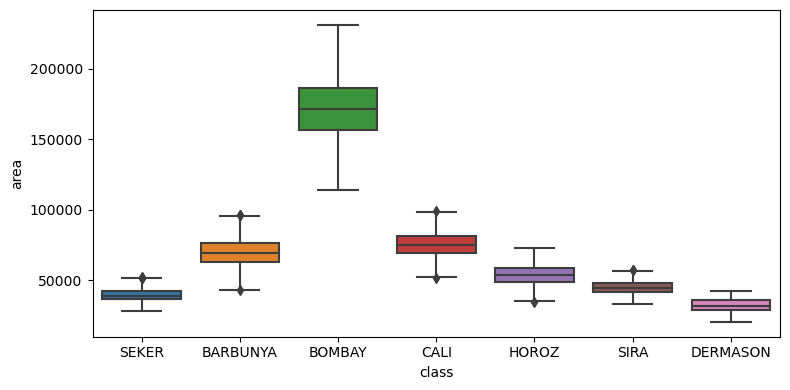

In [15]:
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True
sns.boxplot(data=bean_df_no_outliers, x= 'class', y='area')

In [16]:
bean_df_no_outliers['class'].value_counts()

class
DERMASON    3546
SIRA        2622
SEKER       1990
HOROZ       1905
CALI        1601
BARBUNYA    1310
BOMBAY       515
Name: count, dtype: int64

## **Multilinear Regression Using PCA**

Now I will build and implement the linear regression model. To evaluate the performance of the model I will use the r<sup>2</sup> score and the root mean squared error. As we learned in class, the r<sup>2</sup> score measures the proportion of the variance that is captured by the model when making predictions and the RMSE measures the deviation of the residuals. The 'lin_reg_evaluation' function is the core function of the model evaluation that splits the data and performs a k-fold cross validation with 5 splits and 50 repeats to check for overfitting. Then the testing model will be trained and the function will return a plot with the distribution of the residuals against there ideal normal distribution to visually check how the model is performing. Furthermore, the function gives the option to use PCA or not with the desired number of principal components. 

Firstly, I want to evaluate the performance of the model using only 3 principal components without doing any specific feature selection. We can see right away that the residuals are not as normally distributed as we would like. However, we have an RMSE of 11065 and r<sup>2</sup> score of 0.856 which are fairly solid metrics. My main concern, however, is with the distribution of the residuals, which will never be perfect, but if I can find a way to get the residuals to be more normally distributed, that would be ideal for optimizing the performance of this linear regression

In [18]:
def lin_reg_evaluation(X, y, n_repeats=50, pca = True, n_pc=10):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
    
    cv = RepeatedKFold(n_splits=5, random_state=1234, n_repeats=n_repeats)
    splitting = cv.split(X=X_train, y=y_train)
    
    RMSEs = []
    train_r2_scores = []
    test_r2_scores = []
    
    for train_index, test_index in splitting:
        
        X_subtraining = X_train.iloc[train_index, :]
        X_subtesting = X_train.iloc[test_index, :]
        y_subtraining = y_train.iloc[train_index, :]
        y_subtesting = y_train.iloc[test_index, :]
        
        scaler = StandardScaler()
        scaler.fit(X_subtraining)
        X_subtraining = scaler.transform(X_subtraining)
        X_subtesting = scaler.transform(X_subtesting)

        if pca == True:
            pca_model = PCA(n_components=n_pc)
            pca_model.fit(X_subtraining) 
            X_subtraining = pca_model.transform(X_subtraining) 
            X_subtesting = pca_model.transform(X_subtesting)
        
        lm_model = LinearRegression()
        lm_model.fit(X=X_subtraining, y=y_train.iloc[train_index, :])
        y_pred = lm_model.predict(X_subtesting)
        
        train_r2_score = lm_model.score(X=X_subtraining, y=y_subtraining)
        test_r2_score = lm_model.score(X=X_subtesting, y=y_subtesting)
        RMSE = mean_squared_error(y_true=y_subtesting, y_pred=y_pred, squared=False)
    
        RMSEs.append(RMSE)
        train_r2_scores.append(train_r2_score)
        test_r2_scores.append(test_r2_score)

    print("K-Fold Cross Validation Performance:")
    print(f"train_R^2: {np.mean(train_r2_scores)}\ntest_R^2: {np.mean(test_r2_scores)}\nRMSE: {np.mean(RMSEs)}\n")

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    if pca == True:
        pca_model = PCA(n_components=n_pc)
        pca_model.fit(X_train) 
        X_train = pca_model.transform(X_train) 
        X_test = pca_model.transform(X_test)
    
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)
    
    y_pred = lm_model.predict(X_test)
    
    residuals = (np.array(y_test) - y_pred)[:, 0]
    RMSE = residuals.std()
    R2_square = lm_model.score(X_test, y_test) 
    print("Test Dataset Performance:")
    print(f"R^2: {R2_square}\nRMSE: {RMSE}\n")

    plt.rcParams["figure.figsize"] = [7, 2]
    plt.rcParams["figure.autolayout"] = True
    plt.tight_layout()
    sns.kdeplot(x=residuals, fill=True, alpha=0.2);
    sns.histplot(x=residuals, fill=True, alpha=0.2, stat='density', bins=20);
    sns.kdeplot(x=np.random.normal(scale=RMSE, size=10000), fill=True, alpha=0.2, color='purple');

K-Fold Cross Validation Performance:
train_R^2: 0.8580941436320979
test_R^2: 0.8576244839297698
RMSE: 11075.311966478113

Test Dataset Performance:
R^2: 0.8557369259057583
RMSE: 11065.909147378075



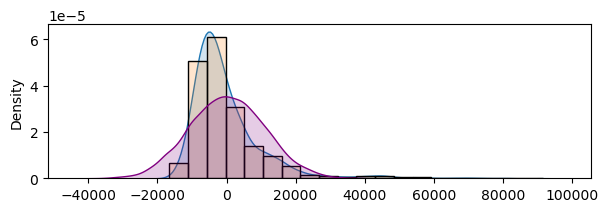

In [19]:
X = bean_df.drop(columns=['area', 'convex_area', 'class', 'equiv_diameter'])
y = bean_df[['area']]
lin_reg_evaluation(X, y, pca=True, n_pc=3)

## **Multilinear Regression Without PCA**

Now that I have evaluated the performance of the linear regression model with 3 principal components, I want to see how this stacks up against a model using the three best regressors that I found from earlier ('perimeter', 'major_axis_length', 'minor_axis_length'). Looking strictly at the performance metrics we can see improvements in performance across the board with an RMSE of 9116 and an r<sup>2</sup> score of 0.90. However, when looking at the residuals plot, there is not much clear improvement when comparing the blue density curve (true density) from before and after. However, I also wanted to implement the dataframe without outliers that I created earlier to see if that would help boost the performance in any way. As we can see, removing the outliers does help to improve the RMSE bringing it down to 8898, however it barely affects the r<sup>2</sup> score unfortunately. This means that the model is capturing almost the same proportion of the variance as before, but being generally more accurate when doing so. However, the distribution of the residuals is not much improved. This could simply be the nature of the data, as there do not seem to be many ways to get more normally distributed residuals. Overall, I am disappointed in the performance boost seen when removing outliers but it does slightly improve performance nonetheless.  

K-Fold Cross Validation Performance:
train_R^2: 0.9037192157903637
test_R^2: 0.9033321341805379
RMSE: 9124.181874493577

Test Dataset Performance:
R^2: 0.9020757586006288
RMSE: 9116.87947733461



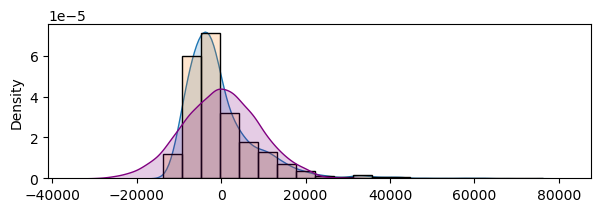

In [20]:
X = bean_df[['perimeter', 'major_axis_length', 'minor_axis_length']]
y = bean_df[['area']]
lin_reg_evaluation(X, y, pca=False)

K-Fold Cross Validation Performance:
train_R^2: 0.9044894052127007
test_R^2: 0.9041600761246539
RMSE: 8995.407013224134

Test Dataset Performance:
R^2: 0.9043853089374857
RMSE: 8898.502825825342



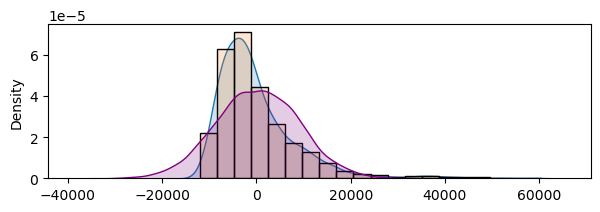

In [21]:
X = bean_df_no_outliers[['perimeter', 'major_axis_length', 'minor_axis_length']]
y = bean_df_no_outliers[['area']]
lin_reg_evaluation(X, y, pca=False)

## **Three Most Adequate Classification Learners**

Now it is time to move onto the classification task. My goal is to identify and train the three most adequate classification learners to decide which one is best to optimize. To do this I have the 'classification_model_evaluation()' function which is similar to the linear regression function in the sense that it will split the data, perform a cross validation, choose whether or not to use PCA, train the model, etc. However, one key difference is that I also have the 'learner' parameter which allows me to easily study the performance of different learners without having to create new functions for each model, which would be unnecessarily tedious. Furthermore, I will evaluate the performance of each classification learner based on the logistic loss and accuracy scores, with much more emphasis being put on evaluating the log loss. Furthermore, the function will return a confusion matrix which will give me insight into how well the model is performing on each class of bean, which could give insight into possible ways to adjust the class weights. So, the three classification learners I will train are logistic regression, random forest, and neural network. When training these models I will not use any PCA or hypertuning of parameters so I can see how these models are performing at baseline. As we can see from the performance of the three models below, the neural network appears to be performing the best in terms of both the log loss and accuracy. Further, the random forest has the overall worst performance. This could also be because I decided to limit the depth of each tree and the number of learners in the interest of run time. It became apparent after training these two learners that they are not at all computationally efficient. The neural network took by far the longest to train, which is at least warranted by the great performance it has. However, the random forest had a similarly long run time with none of the performance benefits of the neural network. It is simply not efficient to use these two learners especially when considering that I also have to perform k-fold validations to check for overfitting. Thus, my learner of choice for performance optimization will be the logistic regression because it is much faster then the other methods and also performs fairly well with a baseline log loss of 0.22 and accuracy of 92%. Furthermore, we can see that these three learners all struggle a bit when attempting to discern between the 'SIRA' and 'DERMASON' classes. On the other hand, they all perform well on the 'BOMBAY' class with little to no misclassifications, which supports the analysis from earlier.  

In [74]:
def classification_model_evaluation(X, y, pca=True, smote=False, n_pc=10, n_repeats=50, test_size=.25, learner=LogisticRegression(max_iter=10000)):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=12345)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=12345)
    splitting = cv.split(X=X_train, y=y_train)

    kf_train_accuracies = []
    kf_test_accuracies = []
    kf_log_losses = []
    kf_y_true = np.array([])
    kf_y_pred = np.array([])

    for train_index, test_index in splitting:
        
        X_subtrain = X_train.iloc[train_index, :]
        X_subtest = X_train.iloc[test_index, :]
        y_subtrain = y_train.iloc[train_index, :]
        y_subtest = y_train.iloc[test_index, :]

        scaler = StandardScaler()
        scaler.fit(X_subtrain)
        X_subtrain = scaler.transform(X_subtrain)
        X_subtest = scaler.transform(X_subtest)

        # if smote == True:
        #     sm = SMOTE(random_state=1234)
        #     X_subtrain, y_subtrain = sm.fit_resample(X_subtrain, y_subtrain)
        
        if pca == True:
            pca_model = PCA(n_components=n_pc)
            pca_model.fit(X_subtrain) 
            X_subtrain = pca_model.transform(X_subtrain)
            X_subtest = pca_model.transform(X_subtest)

        if smote == True:
            sm = SMOTE(random_state=1234)
            X_subtrain, y_subtrain = sm.fit_resample(X_subtrain, y_subtrain)

        learner = learner
        learner.fit(X=X_subtrain, y=y_subtrain.values.ravel())
        y_pred = learner.predict(X_subtest)
        y_pred_prob = learner.predict_proba(X_subtest)
        
        kf_train_accuracies.append(learner.score(X=X_subtrain, y=y_subtrain))
        kf_test_accuracies.append(learner.score(X=X_subtest, y=y_subtest))
        kf_log_losses.append(log_loss(y_true=y_subtest, y_pred=y_pred_prob))
        kf_y_true = np.concatenate((kf_y_true, np.array(y_subtest).flatten()))
        kf_y_pred = np.concatenate((kf_y_pred, np.array(y_pred).flatten()))

    kf_train_accuracy = np.mean(kf_train_accuracies)
    kf_test_accuracy = np.mean(kf_test_accuracies)
    kf_log_loss = np.mean(kf_log_losses)

    print("K-Fold Cross Validation Performance")
    print(f"""k-fold train accuracy: {kf_train_accuracy}\nk-fold test accuracy: {kf_test_accuracy}\nk-fold log loss: {kf_log_loss}""")

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # if smote == True:
    #     sm = SMOTE(random_state=1234)
    #     X_train, y_train = sm.fit_resample(X_train, y_train)

    if pca == True:
        pca_model = PCA(n_components=n_pc)
        pca_model.fit(X_train) 
        X_train = pca_model.transform(X_train)
        X_test = pca_model.transform(X_test)

    if smote == True:
        sm = SMOTE(random_state=1234)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        
    learner = learner
    learner.fit(X=X_train, y=y_train.values.ravel())
    y_pred = learner.predict(X_test)
    y_pred_prob = learner.predict_proba(X_test)

    train_accuracy = learner.score(X=X_train, y=y_train)
    test_accuracy = learner.score(X=X_test, y=y_test)
    test_log_loss = log_loss(y_true=y_test, y_pred=y_pred_prob)
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    plt.rcParams["figure.autolayout"] = True
    plt.xticks(rotation = 25)
    ConfusionMatrixDisplay.from_predictions(kf_y_true, kf_y_pred, colorbar=False, ax=ax[0], xticks_rotation=25)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, ax=ax[1], xticks_rotation=25)
    ax[0].set_title("K-Fold Confusion Matrix")
    ax[1].set_title("Test Confusion Matrix")

    print("\nTesting Data Performance")
    print(f"""train accuracy: {train_accuracy}\ntest accuracy: {test_accuracy}\nlog loss: {test_log_loss}""")

K-Fold Cross Validation Performance
k-fold train accuracy: 0.9256122911326236
k-fold test accuracy: 0.9242754675095892
k-fold log loss: 0.215763400652151

Testing Data Performance
train accuracy: 0.9254506269592476
test accuracy: 0.9224213928886277
log loss: 0.22253968621279882


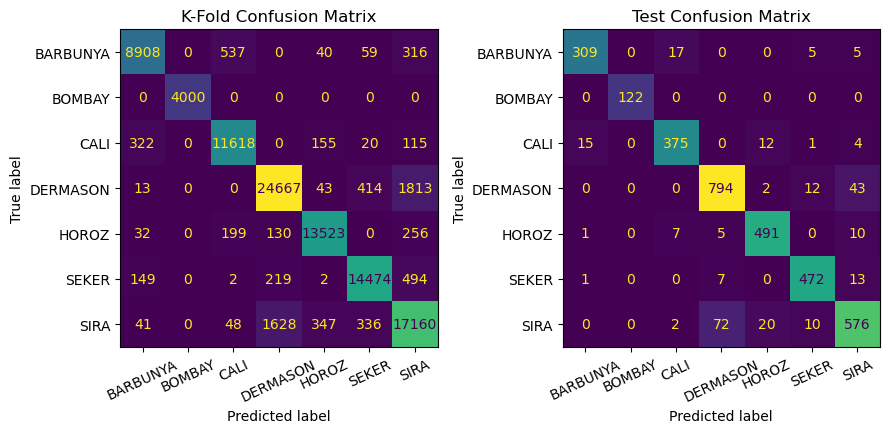

In [23]:
X = bean_df.drop(columns=['class'])
y = bean_df[['class']]
classification_model_evaluation(X, y, pca=False, n_repeats=10, learner=LogisticRegression(max_iter=10000))

K-Fold Cross Validation Performance
k-fold train accuracy: 0.9698275477127429
k-fold test accuracy: 0.921695209037455
k-fold log loss: 0.23401817886388118

Testing Data Performance
train accuracy: 0.9663009404388715
test accuracy: 0.9186012342051131
log loss: 0.24827903966883053


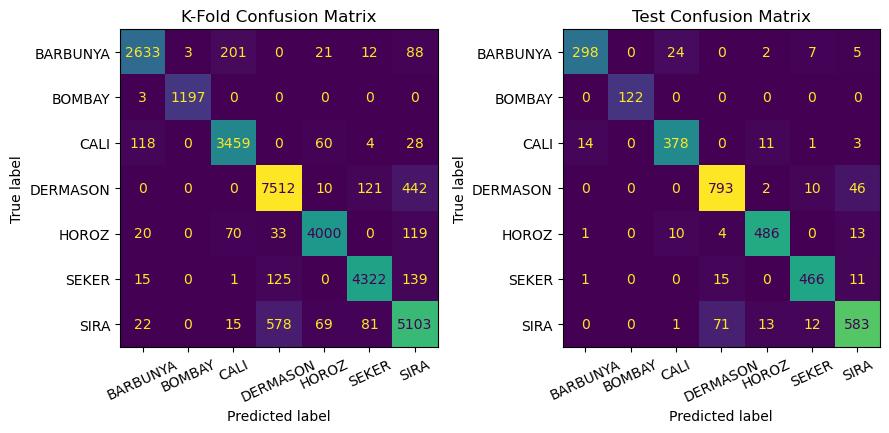

In [24]:
classification_model_evaluation(X, y, pca=False, n_repeats=3, learner=RandomForestClassifier(random_state=1234, max_depth=10, n_estimators=50))

K-Fold Cross Validation Performance
k-fold train accuracy: 0.9473194370020922
k-fold test accuracy: 0.9337680247639629
k-fold log loss: 0.18090311802851178

Testing Data Performance
train accuracy: 0.9443455911427442
test accuracy: 0.937444411503113
log loss: 0.1613632189979862


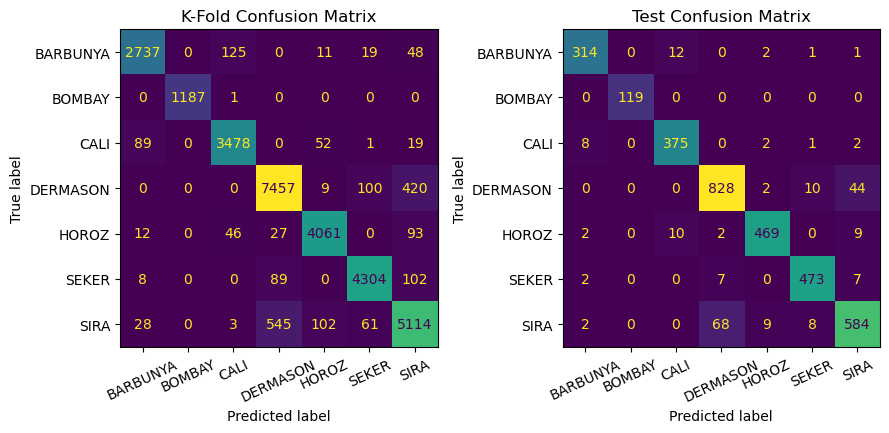

In [27]:
classification_model_evaluation(X, y, pca=False, n_repeats=3, learner=MLPClassifier(random_state=1234, max_iter=1000))

## **Optimizing the Logistic Regression**

As stated earlier, we can see that the overall performance of the baseline logistic regression was quite solid. However, I want to also see if I can further improve the metrics, focusing mostly on optimizing the log loss. So, my first optimization tool was the implemententation of PCA. I experimented with different numbers of principal components and found that 7 principal components gave the best balance of performance boosting and dimensionality reduction. Using more then 7 principal components had negligible benefits for the performance. Next, I attempted to remove some features to further reduce the dimension of the data and found that I could remove the 6 features below with little to no penalty in performance, which further improves the computational efficiency of the model. I also experimented a bit more with PCA after this change and still found that 7 principal components worked best. I was also curious to see if removing the outliers similar to before would benefit the performance, which it did. In fact, removing the outliers was actually one of the most significant ways to reduce the log loss. Furthermore, after analysing the confusion matrices I wanted to experiment with class weight adjustments to see if I could address the misclassifications between 'SIRA' and 'DERMASON'. So, I found that increasing the weights of the 'SIRA' and 'DERMASON' classes to 1.5 while also reducing the weight of the 'BOMBAY' class to 0.5 helped to reduce the log loss by a fair amount. So, by hypertuning these parameters while reducing the dimension of the dataset in various ways I was able to reduce the log loss to 0.188 from the original 0.222, boost the accuracy to 93%, and make the learner much more efficient to train. My final attempt to optimize the model was to address the issue of the data imbalance. However, I was struggling to find good ways to rebalance the data, because undersampling would force me to cut out huge amounts of data. So, I decided to try using SMOTE to rebalance the data. To avoid data leaking, I only resampled the training data in both the cross validation and testing. However, I found that using SMOTE actually led to a small decrease in performance, increasing the log loss slightly to 0.19 and very slighty decreasing the accuracy by 0.2%. So, I decided that SMOTE was not an effective tool for optimizing the model in this case as it only increases runtime and has no performance benefits. Perhaps, there are other ways to deal with the data imbalance, however I was personally unable to find a solution on that end. 

K-Fold Cross Validation Performance
k-fold train accuracy: 0.9273724468745348
k-fold test accuracy: 0.9260968037528892
k-fold log loss: 0.20951692748390405

Testing Data Performance
train accuracy: 0.927145116646896
test accuracy: 0.9297361399347762
log loss: 0.1926227034405874


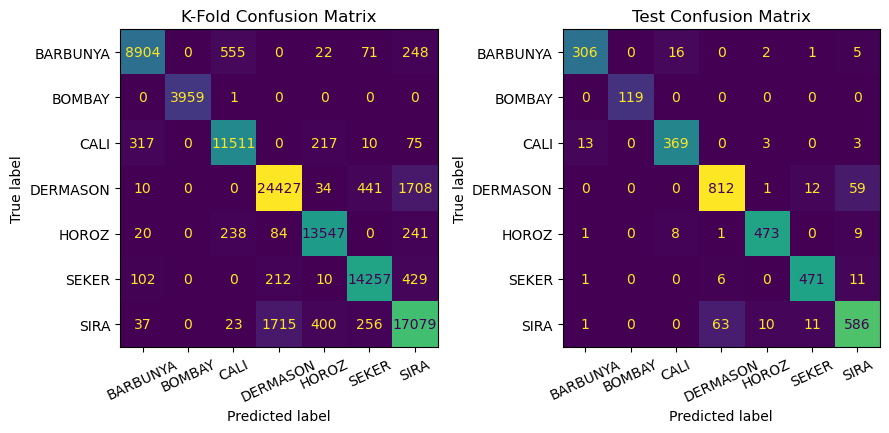

In [65]:
X = bean_df_no_outliers.drop(columns=['class', 'equiv_diameter', 'convex_area', 'compactness', 'perimeter', 'eccentricity', 'aspect_ratio'])
y = bean_df_no_outliers[['class']]
classification_model_evaluation(X, y, pca=True, n_pc=7, n_repeats=10, 
                                learner=LogisticRegression(max_iter=10000))

K-Fold Cross Validation Performance
k-fold train accuracy: 0.9284252424194541
k-fold test accuracy: 0.926976636271807
k-fold log loss: 0.20779729292762295

Testing Data Performance
train accuracy: 0.928232502965599
test accuracy: 0.9300326119181738
log loss: 0.18841289849785922


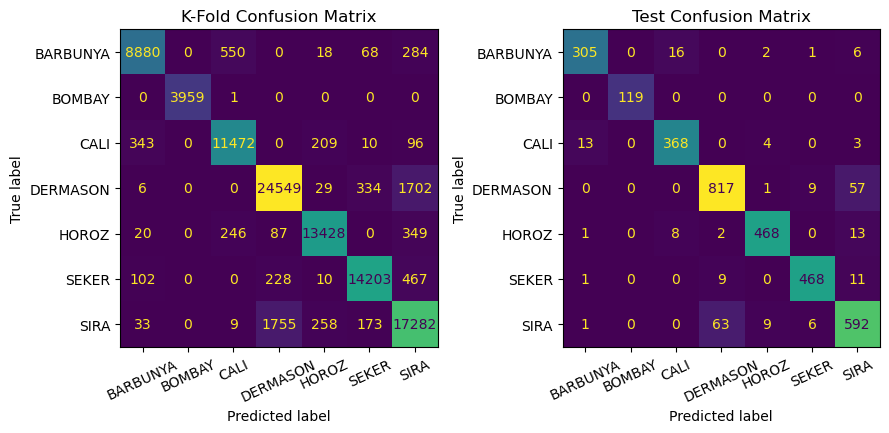

In [66]:
classification_model_evaluation(X, y, pca=True, n_pc=7, n_repeats=10, 
                                learner=LogisticRegression(max_iter=10000, class_weight={'SIRA':1.5, 'DERMASON':1.5, 'BOMBAY': 0.5}, C=10))

K-Fold Cross Validation Performance
k-fold train accuracy: 0.9452032238936157
k-fold test accuracy: 0.9245743124034084
k-fold log loss: 0.2080303757572879

Testing Data Performance
train accuracy: 0.9437587206182247
test accuracy: 0.9285502520011859
log loss: 0.19058188339701934


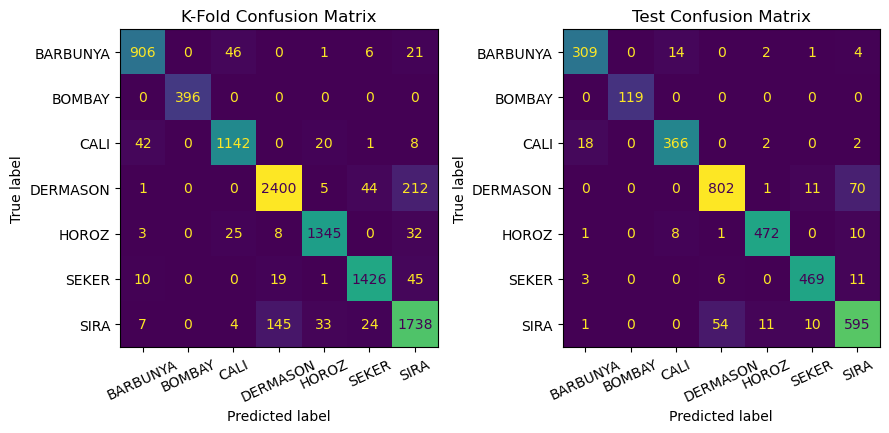

In [73]:
classification_model_evaluation(X, y, smote=True, pca=True, n_pc=7, n_repeats=1, 
                                learner=LogisticRegression(max_iter=10000, class_weight={'SIRA':1.5, 'DERMASON':1.5, 'BOMBAY': 0.5}, C=10))